### Task 1-2. Dive deeper into Stable Diffusion
#### Import modules from Diffusers Library

In [1]:
import os
from os.path import join

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

# Set CUDA device
device = torch.device('cuda:8' if torch.cuda.is_available() else 'cpu')

2023-07-18 14:47:59.361265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### Define utility functions

In [2]:
''' Fix the seed for for reproducibility '''
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

''' Given the SD version, return its Huggingface model ID '''
def set_sd_model_id(sd_version):
    if sd_version == "v1-4":
        model_id = "CompVis/stable-diffusion-v1-4"
    elif sd_version == "v1-5":
        model_id = "runwayml/stable-diffusion-v1-5"
    elif sd_version == "v2-0":
        model_id = "stabilityai/stable-diffusion-2"
    elif sd_version == "v2-1":
        model_id = "stabilityai/stable-diffusion-2-1"
    else:
        raise ValueError("Invalid sd_version")
    return model_id

##### Define the Stable Diffusion module and its sampling code
In this task, we will have a deeper look at the inner mechanisms of Stable Diffusion by checking the following:
* Where the VAE encoder, decoder take place in the Latent Diffusion pipeline,
* How a given text prompt is processed and fed into the diffusion process,
* How the DDIM sampling loop is implemented.

**TODO:** Visualize the images decoded from the latent at (i) the current timestep t, and (ii) the initial timestep 0 for every sampling timestep.

<p><img src="assets/latent_diffusion_pipeline.png" width="600"></p>

In [3]:
'''
Stable Diffusion module
'''
class StableDiffusion(nn.Module):
    def __init__(self, sd_version='v1-5', device='cuda'):
        super().__init__()
        self.device = device

        # Set Huggingface model ID
        model_id = set_sd_model_id(sd_version)
        print(f"[INFO] Model ID: {model_id}")

        # Load pretrained modules from Huggingface
        self.vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(self.device)
        self.tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(self.device)
        self.unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(self.device)

        # Freeze models
        for p in self.unet.parameters():
            p.requires_grad_(False)
        for p in self.vae.parameters():
            p.requires_grad_(False)
        for p in self.text_encoder.parameters():
            p.requires_grad_(False)

        self.unet.eval() 
        self.vae.eval()
        self.text_encoder.eval()
        print('[INFO] Loaded Stable Diffusion!')

        # Set DDIM scheduler
        self.scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
        print('[INFO] Loaded DDIM scheduler!')
    
    def get_text_embeddings(self, prompt, negative_prompt=""):
        '''
        Given a text prompt, return the text embeddings.
        '''

        # Tokenize text prompt and obtain embeddings
        text_input = self.tokenizer(prompt, padding='max_length', max_length=self.tokenizer.model_max_length, return_tensors='pt')
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # Repeat for unconditional embeddings
        uncond_input = self.tokenizer(negative_prompt, padding='max_length', max_length=self.tokenizer.model_max_length, return_tensors='pt')
        uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

        # Concatenate conditional and unconditional embeddings
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        return text_embeddings
    
    def decode_latents(self, latents):
        '''
        Decode latents to images using VAE decoder.
        '''
        latents = 1 / 0.18215 * latents
        imgs = self.vae.decode(latents).sample
        imgs = (imgs / 2 + 0.5).clamp(0, 1)
        
        return imgs
    
    def sample(
        self, 
        prompts,
        negative_prompts="",
        num_sampling_steps=50,
        guidance_scale=7.5,
        save_dir="./results",
        save_x_t=False,
        save_x_0=False,
    ):
        '''
        Sample images with Stable Diffusion.
        '''

        if isinstance(prompts, str):
            prompts = [prompts]

        if isinstance(negative_prompts, str):
            negative_prompts = [negative_prompts]
        
        # Create save directory
        if save_x_t:
            os.makedirs(join(save_dir, "x_t_images"), exist_ok=True)
        if save_x_0:
            os.makedirs(join(save_dir, "x_0_images"), exist_ok=True)

        # Obtain text embeddings
        text_embeds = self.get_text_embeddings(prompts, negative_prompts)                   # 2 x 77 x 768

        # Initialize latent (x_T) sampled from Gaussian distribution
        latent = torch.randn((1, self.unet.in_channels, 64, 64)).to(self.device)        # 1 x 4 x 64 x 64

        # Set DDIM scheduler
        self.scheduler.set_timesteps(num_sampling_steps)

        # Sampling loop
        for i, t in enumerate(self.scheduler.timesteps):
            latent_model_input = torch.cat([latent] * 2)                                # 2 x 4 x 64 x 64

            # Predict the noise with Unet
            noise_pred = self.unet(
                latent_model_input,                           # latent at timestep t
                t,                                            # timestep
                encoder_hidden_states=text_embeds,            # text embeddings
            )['sample']

            # Perform classifier-free guidance (CFG)
            noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

            # `Denoise` the latent with the predicted noise
            denoised_outputs = self.scheduler.step(noise_pred, t, latent)

            '''
            NOTE: `denoised_outputs` consists of:
                - `prev_sample`: One-step denoised latent at timestep t-1, x_{t-1}
                - `pred_original_sample`: Foreseen fully denoised latent at timestep 0, x_0
                    (See DDIM paper for more details)
            '''

            # TODO: Visualize the images decoded from the latent at (i) the current timestep t, and 
            # (ii) the initial timestep 0 for every sampling timestep.
            
            if save_x_t:
                ### Add code here ###
                pass
            if save_x_0:
                ### Add code here ###
                pass

            # Update the latent (x_t -> x_{t-1})
            latent = denoised_outputs['prev_sample']

        # Decode the latent to obtain the image
        img = self.decode_latents(latent)[0].cpu()      # 1 x 3 x 512 x 512
        img = T.ToPILImage()(img)

        return img

##### Initialize the defined Stable Diffusion model

In [4]:
stable_diffusion_model = StableDiffusion(sd_version='v1-5', device=device)

[INFO] Model ID: runwayml/stable-diffusion-v1-5
[INFO] Loaded Stable Diffusion!
[INFO] Loaded DDIM scheduler!


##### Sample images with Stable Diffusion

/tmp/ipykernel_2079376/1234255558.py:94: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latent = torch.randn((1, self.unet.in_channels, 64, 64)).to(self.device)        # 1 x 4 x 64 x 64


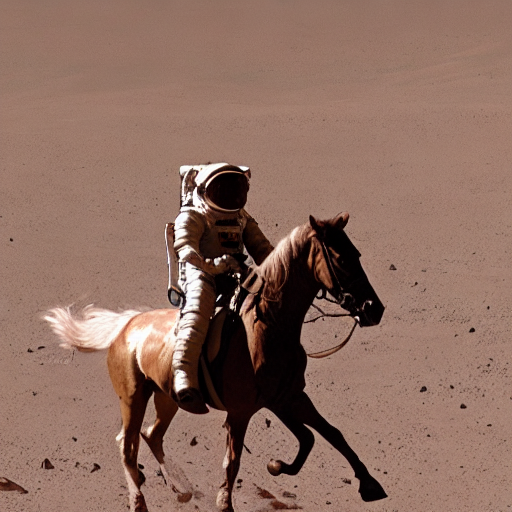

In [9]:
# TODO: Set your own text prompt and seed
prompt = "a photo of an astronaut riding a horse on mars"
negative_prompt = ""

SEED = 13

seed_everything(SEED)

image = stable_diffusion_model.sample(
    prompt, 
    negative_prompt, 
    num_sampling_steps=50,
    guidance_scale=7.5,
    save_dir="./results",
    save_x_t=False,
    save_x_0=False,
)
image